# Cross Validation

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metric
from sklearn.metrics import accuracy_score 

## Dataset Titanic

1. Load Dataset
2. EDA
3. Define X y
4. Data splitting 
5. Preprocessing
6. Cross Validation (mencari model terbaik)
7. Hyperparameter Tuning (pada model terbaik)
8. Predict to Test set 

In [4]:
# df.columns

## 1. Load Dataset

In [5]:
df = sns.load_dataset('titanic')
df = df[['survived', 'pclass', 'sex', 'age', 'parch', 'fare', 'embark_town', 'alone']].copy()
df 

,survived,pclass,sex,age,parch,fare,embark_town,alone
0,0,3,male,22.0,0,7.2500,Southampton,False
1,1,1,female,38.0,0,71.2833,Cherbourg,False
2,1,3,female,26.0,0,7.9250,Southampton,True
3,1,1,female,35.0,0,53.1000,Southampton,False
4,0,3,male,35.0,0,8.0500,Southampton,True
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,13.0000,Southampton,True
887,1,1,female,19.0,0,30.0000,Southampton,True
888,0,3,female,NaN,2,23.4500,Southampton,False
889,1,1,male,26.0,0,30.0000,Cherbourg,True


In [6]:
df.describe(include='all')

,survived,pclass,sex,age,parch,fare,embark_town,alone
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,889,891
unique,NaN,NaN,2,NaN,NaN,NaN,3,2
top,NaN,NaN,male,NaN,NaN,NaN,Southampton,True
freq,NaN,NaN,577,NaN,NaN,NaN,644,537
mean,0.383838,2.308642,NaN,29.699118,0.381594,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,0.806057,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,0.000000,31.000000,NaN,NaN


In [7]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
parch            0
fare             0
embark_town      2
alone            0
dtype: int64

In [8]:
df.duplicated().sum() 

111

In [9]:
df = df.drop_duplicates()
df.shape 

(780, 8)

## 2. EDA

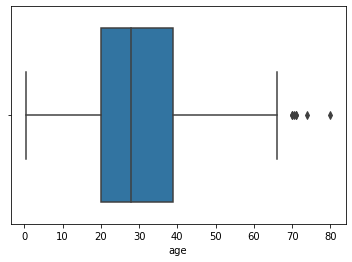

In [10]:
sns.boxplot(data=df, x='age');

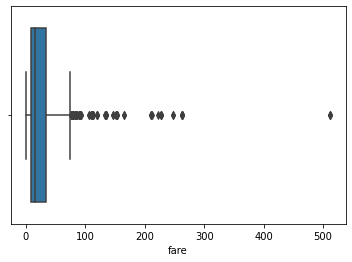

In [11]:
sns.boxplot(data=df, x='fare');

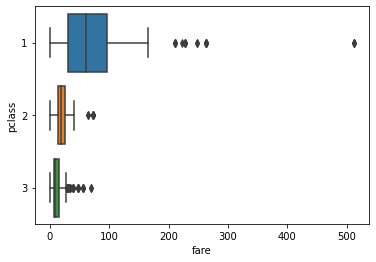

In [12]:
sns.boxplot(data=df, x='fare', y='pclass', orient='h');

In [13]:
# menghapus data dengan pclass=1 dan fare>300

df = df[~((df['pclass']==1) & (df['fare']> 300))]
df.shape 

(777, 8)

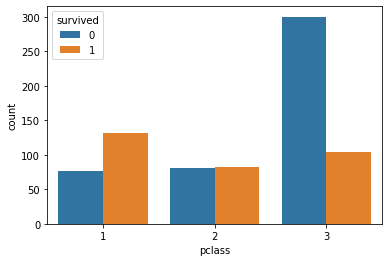

In [14]:
sns.countplot(data=df, x='pclass', hue='survived');

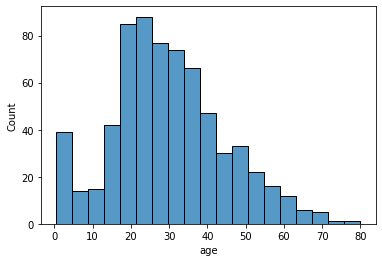

In [15]:
sns.histplot(df['age']);

## 3. Define X and y

In [16]:
X = df.drop(columns='survived')
y = df['survived']

## 4. Data Splitting

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## 5. Preprocessing

Impute:
- IterativeImputer: age
- most_frequent: embark_town

Encoding:
- onehot: sex, embark_town, alone

Scaling:
- RobustScaler: numerical features



In [19]:
# X.describe().columns

In [20]:
# pipeline untuk numerical feature
pipe_iter_robust = Pipeline([
    ('imp_iterative', IterativeImputer()),
    ('robust', RobustScaler())
])

# pipeline untuk 'embark_town'
pipe_mode_onehot = Pipeline([
    ('imp_mode', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

In [21]:
transformer = ColumnTransformer([
    ('pipe_iter_robust', pipe_iter_robust, ['pclass', 'age', 'parch', 'fare']),
    ('pipe_mode_onehot', pipe_mode_onehot, ['embark_town']),
    ('onehot', OneHotEncoder(), ['sex','alone'])
], remainder='passthrough')

In [22]:
# fit
transformer.fit(X_train)

# transform
X_train_prep = transformer.transform(X_train)
X_test_prep = transformer.transform(X_test) 

In [23]:
# features hasil preprocessing
transformer.get_feature_names_out()

array(['pipe_iter_robust__pclass', 'pipe_iter_robust__age',
       'pipe_iter_robust__parch', 'pipe_iter_robust__fare',
       'pipe_mode_onehot__embark_town_Cherbourg',
       'pipe_mode_onehot__embark_town_Queenstown',
       'pipe_mode_onehot__embark_town_Southampton', 'onehot__sex_female',
       'onehot__sex_male', 'onehot__alone_False', 'onehot__alone_True'],
      dtype=object)

## 6. Cross Validation

Mencari model terbaik

In [24]:
from sklearn.model_selection import StratifiedKFold

In [25]:
# define algo
model = LogisticRegression(random_state=0)

# define fold --> bisa digunakan untuk parameter cv
fold = StratifiedKFold(n_splits=5)

# pipeline yg menggabungkan preprocessing dan modeling 
# (agar tidak terjadi information leakage)
pipe_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model) 
])

# cross validation
cv_score = cross_val_score( 
    estimator= pipe_model,  # model
    X = X_train,            # X_train
    y = y_train,            # y_train
    cv = 5,                 # berapa fold
    scoring= 'accuracy'     # metric
) 

print(cv_score)
print(cv_score.mean())
print(cv_score.std()) 

[0.792      0.78225806 0.73387097 0.73387097 0.80645161]
0.7696903225806452
0.030242733580866783


In [26]:
# import sklearn
# sklearn.metrics.get_scorer_names()

### Looping

In [27]:
# algo
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier() 
tree = DecisionTreeClassifier(random_state=0)

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
# list algo
list_algo = [logreg, knn, tree]

list_all_score = []
list_mean = []
list_std = [] 

# looping
for algo in list_algo:

    # define algo
    model = algo

    # define fold --> bisa digunakan untuk parameter cv
    fold = StratifiedKFold(n_splits=5)

    # pipeline yg menggabungkan preprocessing dan modeling 
    # (agar tidak terjadi information leakage)
    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    # cross validation
    cv_score = cross_val_score( 
        estimator= pipe_model,  # model
        X = X_train,            # X_train
        y = y_train,            # y_train
        cv = 5,                 # berapa fold
        scoring= 'accuracy'     # metric
    ) 

    list_all_score.append(cv_score.round(2))
    list_mean.append(cv_score.mean())
    list_std.append(cv_score.std()) 

In [30]:
df_cv = pd.DataFrame()
df_cv['algo'] = list_algo
df_cv['mean_acc'] = list_mean
df_cv['std_acc'] = list_std
df_cv['all_acc'] = list_all_score

df_cv

,algo,mean_acc,std_acc,all_acc
0,LogisticRegression(random_state=0),0.769690,0.030243,"[0.79, 0.78, 0.73, 0.73, 0.81]"
1,KNeighborsClassifier(),0.748761,0.020358,"[0.77, 0.74, 0.72, 0.74, 0.77]"
2,DecisionTreeClassifier(random_state=0),0.735910,0.031596,"[0.74, 0.73, 0.78, 0.69, 0.75]"


Model terbaik:
- mean score paling tinggi (paling akurat)
- std score paling rendah (paling stabil)

Model terbaiknya adalah LogisticRegression

## 7. Hyperparameter Tuning

Mencari hyperparameter terbaik

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
# ?LogisticRegression

In [33]:
# untuk param_grid
hyperparam = {
    'modeling__C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

# untuk estimator
pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', logreg)
    ])

# define gridsearch
gridsearch = GridSearchCV(
    estimator= pipe_model,
    param_grid= hyperparam,
    cv = 5,
    scoring='accuracy',
    n_jobs= -1
)

In [34]:
# fit
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipe_iter_robust',
                                                                         Pipeline(steps=[('imp_iterative',
                                                                                          IterativeImputer()),
                                                                                         ('robust',
                                                                                          RobustScaler())]),
                                                                         ['pclass',
                                                                          'age',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('pipe_mode_onehot',
                                                                         Pipeline(steps=[('imp_mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['embark_town']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'alone'])])),
                                       ('modeling',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid={'modeling__C': [10000, 1000, 100, 10, 1, 0.1, 0.01,
                                         0.001, 0.0001, 1e-05]},
             scoring='accuracy')

In [35]:
# hasil cross validation mencari hyperparameter terbaik
pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.077522,0.009888,0.022598,0.003449,10000,{'modeling__C': 10000},0.800,0.790323,0.750000,0.733871,0.806452,0.776129,0.028842,1
1,0.084256,0.011776,0.018981,0.002950,1000,{'modeling__C': 1000},0.800,0.790323,0.750000,0.733871,0.806452,0.776129,0.028842,1
2,0.070403,0.019524,0.018138,0.008737,100,{'modeling__C': 100},0.800,0.790323,0.750000,0.733871,0.806452,0.776129,0.028842,1
3,0.061077,0.013478,0.015349,0.002968,10,{'modeling__C': 10},0.800,0.790323,0.750000,0.733871,0.806452,0.776129,0.028842,1
4,0.071459,0.009843,0.018474,0.002916,1,{'modeling__C': 1},0.792,0.782258,0.733871,0.733871,0.806452,0.769690,0.030243,5
5,0.078161,0.025770,0.018012,0.003811,0.1,{'modeling__C': 0.1},0.768,0.750000,0.741935,0.733871,0.830645,0.764890,0.034768,6
6,0.076703,0.006460,0.022033,0.004647,0.01,{'modeling__C': 0.01},0.760,0.709677,0.701613,0.685484,0.774194,0.726194,0.034587,7
7,0.072126,0.004144,0.019279,0.004695,0.001,{'modeling__C': 0.001},0.616,0.596774,0.629032,0.612903,0.604839,0.611910,0.010863,8
8,0.059552,0.008412,0.016634,0.004202,0.0001,{'modeling__C': 0.0001},0.592,0.588710,0.588710,0.588710,0.588710,0.589368,0.001316,9
9,0.059025,0.005011,0.017015,0.004738,0.00001,{'modeling__C': 1e-05},0.592,0.588710,0.588710,0.588710,0.588710,0.589368,0.001316,9


In [36]:
# best score
gridsearch.best_score_

0.7761290322580645

In [37]:
# best hyperparameter
gridsearch.best_params_ 

{'modeling__C': 10000}

In [38]:
# best model 
gridsearch.best_estimator_ 

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_iter_robust',
                                                  Pipeline(steps=[('imp_iterative',
                                                                   IterativeImputer()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['pclass', 'age', 'parch',
                                                   'fare']),
                                                 ('pipe_mode_onehot',
                                                  Pipeline(steps=[('imp_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['embark_town']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['sex', 'alone'])])),
                ('modeling', LogisticRegression(C=10000, random_state=0))])

Performa model di train set
- Accuracy sebelum hyperparameter tuning: 0.769
- Accuracy setelah hyperparameter tuning: 0.776

Performa model meningkat setelah hyperparameter tuning

## 8. Predict to Testset

**Sebelum tuning**

In [39]:
# define model
pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', logreg)
    ])

# fit
pipe_model.fit(X_train, y_train)

# predict
y_pred_before = pipe_model.predict(X_test)

# accuracy
accuracy_score(y_test, y_pred_before)

0.7948717948717948

**Setelah tuning**

In [40]:
# best model
logreg_tuning = LogisticRegression(random_state=0, C=10000)

# define model
pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', logreg_tuning)
    ])

# fit
pipe_model.fit(X_train, y_train)

# predict
y_pred_after = pipe_model.predict(X_test)

# accuracy
accuracy_score(y_test, y_pred_after)

0.8012820512820513

In [41]:
print('Before tuning', accuracy_score(y_test, y_pred_before)) 
print('After tuning', accuracy_score(y_test, y_pred_after)) 

Before tuning 0.7948717948717948
After tuning 0.8012820512820513


In [42]:
from sklearn.metrics import confusion_matrix

In [2]:
# confusion_matrix(y_test, y_pred_after)

NameError: name 'confusion_matrix' is not defined